In [ ]:
import requests
import json
import urllib
import datetime
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/gdrive')

# Грузим данные

In [ ]:
#deribit
start_time = datetime.datetime(2021,7,6,0,0,0)
start_time = str(int(start_time.timestamp())*1000)
end_time = datetime.datetime(2021,7,10,0,0,0)
end_time = str(int(end_time.timestamp())*1000)
has_more = Trueёё
trades = {'price':[],'timestamp':[],'time':[]}
while has_more == True:
  request = 'https://deribit.com/api/v2/public/get_last_trades_by_instrument_and_time?count=1000&start_timestamp='+start_time+'&end_timestamp='+end_time+'&instrument_name=BTC-24SEP21'
  response = urllib.request.urlopen(request)
  result = response.read()
  has_more = json.loads(result)['result']['has_more']
  print(has_more)
  result = json.loads(result)['result']['trades']
  for i in result:
    trades['price'].append(i['price'])
    trades['timestamp'].append(i['timestamp'])
    trades['time'].append(pd.to_datetime(datetime.datetime.fromtimestamp(i['timestamp']/1000).strftime('%Y-%m-%d %H:%M:%S')))
  start_time = str(np.max(trades['timestamp']))
DERIBIT_trades = pd.DataFrame(trades)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False


In [ ]:
#binance

raw_data_0507 = pd.read_csv("/content/gdrive/My Drive/Quant/data/binance trades/BTCUSDT_210924-trades-2021-07-05.csv", header = None)
raw_data_0607 = pd.read_csv("/content/gdrive/My Drive/Quant/data/binance trades/BTCUSDT_210924-trades-2021-07-06.csv", header = None)
raw_data_0707 = pd.read_csv("/content/gdrive/My Drive/Quant/data/binance trades/BTCUSDT_210924-trades-2021-07-07.csv", header = None)
raw_data_0807 = pd.read_csv("/content/gdrive/My Drive/Quant/data/binance trades/BTCUSDT_210924-trades-2021-07-08.csv", header = None)
raw_data_0907 = pd.read_csv("/content/gdrive/My Drive/Quant/data/binance trades/BTCUSDT_210924-trades-2021-07-09.csv", header = None)
BINANCE_trades = pd.concat([raw_data_0507,raw_data_0607, raw_data_0707, raw_data_0807,raw_data_0907])[[1,4]]
BINANCE_trades.columns = ['price','timestamp']
time = []
for i in range(0,len(BINANCE_trades)):
  time.append(pd.to_datetime(datetime.datetime.fromtimestamp(BINANCE_trades['timestamp'].iloc[i]/1000).strftime('%Y-%m-%d %H:%M:%S')))
BINANCE_trades['time']=time

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
minutes = pd.date_range(start = '2021-07-03 00:00:00',end = '2021-07-05 00:00:00',freq = '1min')
changes = {'time':[],'open':[],'close':[],'high':[],'low':[]}
counter = 0
for i in range(len(minutes)-1):
  bsml = BINANCE_trades[(BINANCE_trades['time']>=minutes[i])&(BINANCE_trades['time']<minutes[i+1])]
  dsml = DERIBIT_trades[(DERIBIT_trades['time']>=minutes[i])&(DERIBIT_trades['time']<minutes[i+1])]
  j = 0
  k = 0
  if (len(dsml)==0 or len(bsml)==0):
    counter+=1
    continue
  last_time_bsml = bsml['timestamp'].iloc[0]
  last_time_dsml = dsml['timestamp'].iloc[0]

  changes['open'].append(dsml['price'].iloc[0] - bsml['price'].iloc[0])
  changes['time'].append(minutes[i])
  changes['close'].append(dsml['price'].iloc[-1] - bsml['price'].iloc[-1])
  
  lilchan = []
  bsml['type'] = [-1 for i in range(len(bsml))]
  dsml['type'] = [1 for i in range(len(dsml))]
  concated = pd.concat([bsml,dsml])
  concated = concated.sort_values(by='timestamp')
  k = 0
  while concated['type'].iloc[k]==1:
    k+=1
  j = 0
  while concated['type'].iloc[j]==-1:
    j+=1
  j=max(j,k)
  last_a = concated.iloc[j]
  last_b = concated.iloc[j-1]
  lilchan.append(concated['price'].iloc[j]*concated['type'].iloc[j]+concated['price'].iloc[j-1]*concated['type'].iloc[j-1])
  j+=1
  
  while(j<len(concated)):
    if last_a['type'] == concated['type'].iloc[j]:
      lilchan.append(lilchan[-1]-last_a['price']*last_a['type']+concated['price'].iloc[j]*concated['type'].iloc[j])
      last_a = concated.iloc[j]
    else:
      lilchan.append(lilchan[-1]-last_b['price']*last_b['type']+concated['price'].iloc[j]*concated['type'].iloc[j])
      last_b = concated.iloc[j]
    #print(last_a['price'], last_b['price'],lilchan[-1])
    j+=1
  #lilchan = []
  a = concated[concated['type']==-1]
  b = concated[concated['type']==1] 
  changes['high'].append(max(lilchan))
  changes['low'].append(min(lilchan))
changes = pd.DataFrame(changes)

# Смотрим характеристики спреда

In [ ]:
beginning = pd.to_datetime('2021-07-06 00:00:00')
ending =   pd.to_datetime('2021-07-10 00:00:00')
feerate = 0.001
changes = {'timestamp':[], 'time':[], 'price':[], 'fee':[], 'prper':[]}
counter = 0
for i in range(0,1):#len(minutes)-1):
  bsml = BINANCE_trades[(BINANCE_trades['time']>=beginning)&(BINANCE_trades['time']<ending)]
  dsml = DERIBIT_trades[(DERIBIT_trades['time']>=beginning)&(DERIBIT_trades['time']<ending)]
 # print(bsml)
 # print(dsml)
  j = 0
  k = 0
  if (len(dsml)==0 or len(bsml)==0):
    counter+=1
    continue

  bsml['type'] = [-1 for i in range(len(bsml))]
  dsml['type'] = [1 for i in range(len(dsml))]
  concated = pd.concat([bsml,dsml])
  concated = concated.sort_values(by='timestamp')
  k = 0
  while concated['type'].iloc[k]==1:
    k+=1
  j = 0
  while concated['type'].iloc[j]==-1:
    j+=1
  j=max(j,k)

  last_a = concated.iloc[j]
  last_b = concated.iloc[j-1]

  changes['price'].append(concated['price'].iloc[j]*concated['type'].iloc[j]+concated['price'].iloc[j-1]*concated['type'].iloc[j-1])
  changes['time'].append(pd.to_datetime(concated['time'].iloc[j]))
  changes['timestamp'].append(concated['timestamp'].iloc[j])
  changes['fee'].append((concated['price'].iloc[j]+concated['price'].iloc[j-1])*feerate)
  changes['prper'].append(concated['price'].iloc[j]+concated['price'].iloc[j-1])
  j+=1
  
  while(j<len(concated)):
    if last_a['type'] == concated['type'].iloc[j]:
      changes['price'].append(changes['price'][-1]-last_a['price']*last_a['type']+concated['price'].iloc[j]*concated['type'].iloc[j])
      last_a = concated.iloc[j]
      changes['time'].append(pd.to_datetime(last_a['time']))
      changes['timestamp'].append(last_a['timestamp'])
      changes['fee'].append((last_a['price']+last_b['price'])*feerate)
      changes['prper'].append(last_a['price']+last_b['price'])
    else:
      changes['price'].append(changes['price'][-1]-last_b['price']*last_b['type']+concated['price'].iloc[j]*concated['type'].iloc[j])
      last_b = concated.iloc[j]
      changes['time'].append(pd.to_datetime(last_b['time']))
      changes['timestamp'].append(last_b['timestamp'])
      changes['fee'].append((last_a['price']+last_b['price'])*feerate)
      changes['prper'].append(last_a['price']+last_b['price'])
    #print(j)
    j+=1

changes = pd.DataFrame(changes)

Text(0.5, 1.0, 'Спреды по уровням в зависимости от времени')

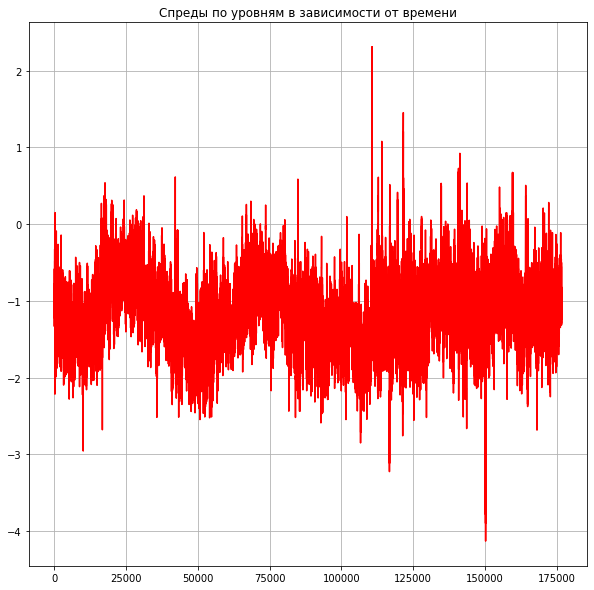

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(range((len(changes))),changes['price']/changes['fee'], color ='red')
plt.grid()
plt.title('Спреды по уровням в зависимости от времени')

In [ ]:
#квантили
hours = pd.date_range(start = '2021-07-06 00:00:00',end = '2021-07-10 00:00:00',freq = '15min')
results = {'mean':[],'std':[],'minmax':[]}
for i in range(len(hours[:-1])):
  lch = changes[(changes['time']>=hours[i])&((changes['time']<hours[i+1]))]
  results['mean'].append(np.mean(lch['price']/lch['fee']))
  results['std'].append(np.std(lch['price']/lch['fee']))
  results['minmax'].append((np.max(lch['price']/lch['fee'])-np.min(lch['price']/lch['fee'])))
results = pd.DataFrame(results)
#results = np.array(results['mean'].iloc[1:].to_list())-np.array(results['mean'].iloc[:-1].to_list())
step = 0.05
print(np.max(results['minmax']),np.std(results['minmax']))
print(' q \t   v')
for i in np.arange(0,1,step):
  print(np.around(i+step,2),'\t',np.around(np.quantile(np.array(results['mean'].iloc[1:].to_list())-np.array(results['mean'].iloc[0:-1].to_list()),i+step),2))

4.584202755085095 0.5235881706349942
 q 	   v
0.05 	 -0.29
0.1 	 -0.23
0.15 	 -0.19
0.2 	 -0.15
0.25 	 -0.11
0.3 	 -0.09
0.35 	 -0.07
0.4 	 -0.05
0.45 	 -0.02
0.5 	 0.0
0.55 	 0.02
0.6 	 0.05
0.65 	 0.06
0.7 	 0.08
0.75 	 0.11
0.8 	 0.14
0.85 	 0.18
0.9 	 0.23
0.95 	 0.3
1.0 	 0.66


In [ ]:
#квантили
hours = pd.date_range(start = '2021-07-06 00:00:00',end = '2021-07-10 00:00:00',freq = '15min')
results = {'mean':[],'std':[],'minmax':[]}
for i in range(len(hours[:-1])):
  lch = changes[(changes['time']>=hours[i])&((changes['time']<hours[i+1]))]
  results['mean'].append(np.mean(lch['price']))
  results['std'].append(np.std(lch['price']))
  results['minmax'].append((np.max(lch['price'])-np.min(lch['price'])))
results = pd.DataFrame(results)
#results = np.array(results['mean'].iloc[1:].to_list())-np.array(results['mean'].iloc[:-1].to_list())
step = 0.05
print(np.max(results['minmax']),np.std(results['minmax']))
print(' q \t   v')
for i in np.arange(0,1,step):
  print(np.around(i+step,2),'\t',np.around(np.quantile(np.array(results['mean'].iloc[1:].to_list())-np.array(results['mean'].iloc[0:-1].to_list()),i+step),2))

4.584202755085095 0.5235881706349942
 q 	   v
0.05 	 -0.29
0.1 	 -0.23
0.15 	 -0.19
0.2 	 -0.15
0.25 	 -0.11
0.3 	 -0.09
0.35 	 -0.07
0.4 	 -0.05
0.45 	 -0.02
0.5 	 0.0
0.55 	 0.02
0.6 	 0.05
0.65 	 0.06
0.7 	 0.08
0.75 	 0.11
0.8 	 0.14
0.85 	 0.18
0.9 	 0.23
0.95 	 0.3
1.0 	 0.66


Text(0.5, 1.0, 'Распределение спреда в зависимости от доли от сборов')

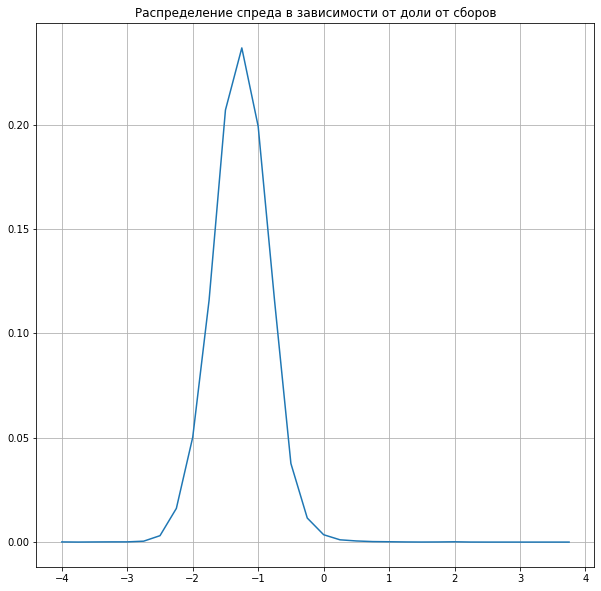

In [ ]:
fees = []
step = 0.25
for i in np.arange(-4,4,step):
  fees.append(len((changes[(changes['price']<changes['fee']*(i+step)) & (changes['price'] >= changes['fee']*i)]))/len(changes))
plt.figure(figsize = (10,10))
plt.plot(np.arange(-4,4,step),fees)
plt.grid()
plt.title('Распределение спреда в зависимости от доли от сборов')


In [ ]:
#абсолютные квантили
print(np.mean(changes['price']/changes['fee']))
print(np.std(changes['price']/changes['fee']))
step = 0.05
print(' q \t   v')
levels = {'квантиль':[], 'цена/сбор':[], 'цена абс.':[],'цена отн.':[]}
for i in np.arange(0,1,step):
  print(np.around(i+step,2),'\t',np.around(np.quantile(changes['price']/changes['fee'],i+step),2))
  levels['квантиль'].append(i+step)
  levels['цена/сбор'].append(np.around(np.quantile(changes['price']/changes['fee'],i+step)))
#print(' ')
for i in np.arange(0,1,step):
  print(np.around(i+step,2),'\t',np.around(np.quantile(changes['price'],i+step),2))
  levels['цена абс.'].append(np.around(np.quantile(changes['price'],i+step),2))
#print(' ')
for i in np.arange(0,1,step):
  print(np.around(i+step,2),'\t',np.around(np.quantile(changes['price']/changes['prper'],i+step),5))
  levels['цена отн.'].append(np.around(np.quantile(changes['price']/changes['prper'],i+step),5))

-1.1379093171012282
0.4211406566672062
 q 	   v
0.05 	 -1.83
0.1 	 -1.67
0.15 	 -1.56
0.2 	 -1.48
0.25 	 -1.41
0.3 	 -1.35
0.35 	 -1.3
0.4 	 -1.24
0.45 	 -1.19
0.5 	 -1.14
0.55 	 -1.09
0.6 	 -1.03
0.65 	 -0.98
0.7 	 -0.92
0.75 	 -0.86
0.8 	 -0.8
0.85 	 -0.72
0.9 	 -0.62
0.95 	 -0.48
1.0 	 2.31
0.05 	 -124.1
0.1 	 -113.0
0.15 	 -105.7
0.2 	 -100.3
0.25 	 -95.8
0.3 	 -91.7
0.35 	 -87.8
0.4 	 -84.3
0.45 	 -80.8
0.5 	 -77.3
0.55 	 -73.7
0.6 	 -70.1
0.65 	 -66.3
0.7 	 -62.5
0.75 	 -58.4
0.8 	 -53.9
0.85 	 -48.8
0.9 	 -42.5
0.95 	 -32.5
1.0 	 152.8
0.05 	 -0.00183
0.1 	 -0.00167
0.15 	 -0.00156
0.2 	 -0.00148
0.25 	 -0.00141
0.3 	 -0.00135
0.35 	 -0.0013
0.4 	 -0.00124
0.45 	 -0.00119
0.5 	 -0.00114
0.55 	 -0.00109
0.6 	 -0.00103
0.65 	 -0.00098
0.7 	 -0.00092
0.75 	 -0.00086
0.8 	 -0.0008
0.85 	 -0.00072
0.9 	 -0.00062
0.95 	 -0.00048
1.0 	 0.00231


In [ ]:
hours = pd.date_range(start = '2021-07-06 00:00:00',end = '2021-07-10 00:00:00',freq = '1H')
levels['1H абс.'] = []
#levels['1H относ.'] = []
for j in range(len(levels['цена абс.'])):
  ka = []
  kr = []
  for t in range(len(hours)-1):
    lch = changes[(changes['time']>=hours[t])&((changes['time']<hours[t+1]))]
    ka.append(len(lch[lch['price']<=levels['цена абс.'][j]]))
    kr.append(ka[-1]/len(lch))
  levels['1H абс.'].append(np.around(np.mean(ka)))
  #levels['1H относ.'].append(np.around(np.mean(kr),4))

In [ ]:
levels['1H абс.']

[92.0,
 184.0,
 276.0,
 370.0,
 461.0,
 551.0,
 646.0,
 736.0,
 830.0,
 921.0,
 1012.0,
 1102.0,
 1197.0,
 1289.0,
 1382.0,
 1473.0,
 1565.0,
 1657.0,
 1749.0,
 1841.0]

In [ ]:
#тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller
adresults = []
hours = pd.date_range(start = '2021-07-05 00:00:00',end = '2021-07-09 00:00:00',freq = '5h')

for i in range(len(hours)-1):
  a = changes[(changes['time']>=hours[i]) & (changes['time']<hours[i+1])]
  if len(a)>0:
   adresults.append(adfuller(a['price']/a['fee'], regression='c')[0])

In [ ]:
np.sum([i<-3.5 for i in adresults])/len(adresults)

1.0

In [ ]:
periods = [300, 600, 1200, 2400]
thresholds = [1,1.2,1.4,1.6,1.8,2.0]
for threshold in thresholds:
  print('\nпороговое значение:',threshold)
  #print('период ск.средней', 'количество сделок', 'ср. профит', 'мин.профит', 'ср. время удержания')
  for period in periods:
    upper = []
    lower = []
    times = []
    memento = 0
    upperflag = False
    lowerflag = False
    consider = pd.DataFrame(changes['price']/changes['fee'])
    consider['time'] = changes['time']
    consider.columns = ['price','time']
    sma = consider['price'].rolling(period).mean()
    for i in range(period, len(consider)):
      #print(consider.iloc[i]-sma.iloc[i])
      if upperflag == False and consider['price'].iloc[i]-sma.iloc[i]>threshold:
        tbeg = consider['time'].iloc[i]
        #memento = consider['price'].iloc[i]
        memento = sma.iloc[i]+threshold
        upperflag = True
      elif upperflag == True and consider['price'].iloc[i]-sma.iloc[i]<0:
        times.append(consider['time'].iloc[i]-tbeg)
        #upper.append(memento - consider['price'].iloc[i])
        upper.append(memento - sma.iloc[i])
        upperflag = False
    print(period,'\t', len(upper),'\t', np.around(np.mean(upper),3),'\t', np.around(np.min(upper),3), '\t', np.mean(times))


пороговое значение: 1
300 	 90 	 0.888 	 -0.159 	 0 days 00:00:29.966666666
600 	 98 	 0.942 	 0.371 	 0 days 00:00:44.397959183
1200 	 101 	 0.967 	 0.639 	 0 days 00:01:00.891089108
2400 	 92 	 0.979 	 0.771 	 0 days 00:01:14.141304347

пороговое значение: 1.2
300 	 40 	 1.035 	 0.055 	 0 days 00:00:21.250000
600 	 44 	 1.111 	 0.571 	 0 days 00:00:28.409090909
1200 	 43 	 1.149 	 0.839 	 0 days 00:00:39.139534883
2400 	 42 	 1.168 	 0.974 	 0 days 00:01:03.238095238

пороговое значение: 1.4
300 	 19 	 1.167 	 0.261 	 0 days 00:00:29.894736842
600 	 24 	 1.295 	 0.771 	 0 days 00:00:28.375000
1200 	 28 	 1.347 	 1.039 	 0 days 00:00:42.785714285
2400 	 28 	 1.364 	 1.175 	 0 days 00:00:47.107142857

пороговое значение: 1.6
300 	 14 	 1.32 	 0.467 	 0 days 00:00:36.642857142
600 	 17 	 1.474 	 0.977 	 0 days 00:00:33.705882352
1200 	 16 	 1.527 	 1.239 	 0 days 00:00:37.437500
2400 	 14 	 1.544 	 1.402 	 0 days 00:00:46.785714285

пороговое значение: 1.8
300 	 11 	 1.477 	 0.722 	 0 

In [ ]:
periods = [300, 600, 1200, 2400]
thresholds = [1,1.2,1.4,1.6,1.8,2.0]
for threshold in thresholds:
  print('\nпороговое значение:',threshold)
  #print('период ск.средней', 'количество сделок', 'ср. профит', 'мин.профит', 'ср. время удержания')
  for period in periods:
    upper = []
    lower = []
    times = []
    memento = 0
    upperflag = False
    lowerflag = False
    consider = pd.DataFrame(changes['price']/changes['fee'])
    consider['time'] = changes['time']
    consider.columns = ['price','time']
    sma = consider['price'].rolling(period).mean()
    for i in range(period, len(consider)):
      #print(consider.iloc[i]-sma.iloc[i])
      if upperflag == False and consider['price'].iloc[i]-sma.iloc[i]<-threshold:
        tbeg = consider['time'].iloc[i]
        #memento = consider['price'].iloc[i]
        memento = sma.iloc[i] - threshold
        upperflag = True
      elif upperflag == True and consider['price'].iloc[i]-sma.iloc[i]>0:
        times.append(consider['time'].iloc[i]-tbeg)
        #upper.append(-memento + consider['price'].iloc[i])
        upper.append(-memento + sma.iloc[i])
        upperflag = False
    print(period,'\t', len(upper),'\t', np.around(np.mean(upper),3),'\t', np.around(np.min(upper),3),'\t', np.mean(times))


пороговое значение: 1
300 	 71 	 0.896 	 0.135 	 0 days 00:00:47.478873239
600 	 82 	 0.951 	 0.617 	 0 days 00:01:01.353658536
1200 	 82 	 0.969 	 0.649 	 0 days 00:01:08.170731707
2400 	 83 	 0.985 	 0.87 	 0 days 00:01:15.927710843

пороговое значение: 1.2
300 	 31 	 1.036 	 0.328 	 0 days 00:01:02.032258064
600 	 31 	 1.138 	 0.817 	 0 days 00:01:31.129032258
1200 	 35 	 1.174 	 1.07 	 0 days 00:01:08
2400 	 32 	 1.186 	 1.156 	 0 days 00:01:39.656250

пороговое значение: 1.4
300 	 17 	 1.207 	 0.529 	 0 days 00:00:51.529411764
600 	 16 	 1.348 	 1.22 	 0 days 00:00:52.312500
1200 	 16 	 1.374 	 1.307 	 0 days 00:00:51.750000
2400 	 16 	 1.386 	 1.356 	 0 days 00:01:33.500000

пороговое значение: 1.6
300 	 8 	 1.342 	 0.841 	 0 days 00:00:29.875000
600 	 8 	 1.54 	 1.42 	 0 days 00:00:23.375000
1200 	 9 	 1.568 	 1.507 	 0 days 00:01:15
2400 	 8 	 1.579 	 1.556 	 0 days 00:01:36.250000

пороговое значение: 1.8
300 	 5 	 1.463 	 1.088 	 0 days 00:00:46.400000
600 	 5 	 1.721 	 1.62

In [ ]:
print(np.mean(upper), np.min(upper),len(upper), np.mean(times))

1.2227614418697164 0.9592884806754045 92 0 days 00:01:14.141304347


In [ ]:
np.mean(times)

Timedelta('0 days 00:01:01.714285714')

# Трейдингвью, но спред считаем сами


In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/gdrive')
BINANCE_candles = pd.read_csv("/content/gdrive/My Drive/Quant/data/tradingview/BINANCE_BTCU2021, 1 (3).csv")
DERIBIT_candles = pd.read_csv("/content/gdrive/My Drive/Quant/data/tradingview/DERIBIT_BTC24U21, 1 (1).csv")
dat = []
for i in range(0,len(DERIBIT_candles)):
  dat.append(pd.to_datetime(datetime.datetime.fromtimestamp(DERIBIT_candles['time'].iloc[i]).strftime('%Y-%m-%d %H:%M:%S')))
DERIBIT_candles['datetime']=dat
dat = []
for i in range(0,len(BINANCE_candles)):
  dat.append(pd.to_datetime(datetime.datetime.fromtimestamp(BINANCE_candles['time'].iloc[i]).strftime('%Y-%m-%d %H:%M:%S')))
BINANCE_candles['datetime']=dat

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
             time     open     high      low    close  Volume  Volume MA
0      1624233600  35817.0  35858.0  35808.5  35858.0    9070        NaN
1      1624233660  35827.0  35827.0  35779.0  35810.0    2130        NaN
2      1624233720  35805.5  35963.0  35805.5  35947.5   12480        NaN
3      1624233780  35949.0  36011.5  35949.0  35993.5    4650        NaN
4      1624233840  35872.0  35872.0  35757.5  35757.5    4060        NaN
...           ...      ...      ...      ...      ...     ...        ...
22157  1625750580  32709.5  32724.0  32709.5  32724.0    2030     8042.5
22158  1625750640  32718.0  32718.0  32717.5  32717.5    5010     7982.5
22159  1625750700  32705.0  32705.0  32705.0  32705.0    4040     8081.5
22160  1625750760  32750.5  32750.5  32749.5  32749.5   23020     9230.0
22161  1625750880  32774.0  32774.0  32758.5  32758.5    2640     

In [ ]:
changes_high = []
changes_low = []
merged = pd.merge(DERIBIT_candles, BINANCE_candles, on = ['datetime'], suffixes = ['DER','BIN'])
merged = merged[merged['datetime']>pd.to_datetime("2021-06-27")]
for i in range(len(merged)):
  changes_high.append((merged['highDER'].iloc[i]-merged['highBIN'].iloc[i])/(merged['highDER'].iloc[i]*0.001+merged['highBIN'].iloc[i]*0.001))
  changes_low.append((merged['lowDER'].iloc[i]-merged['lowBIN'].iloc[i])/(merged['lowDER'].iloc[i]*0.001+merged['lowBIN'].iloc[i]*0.001))
  #changes.append(merged['open_DER'].iloc[i]-merged['close_BIN'].iloc[i])

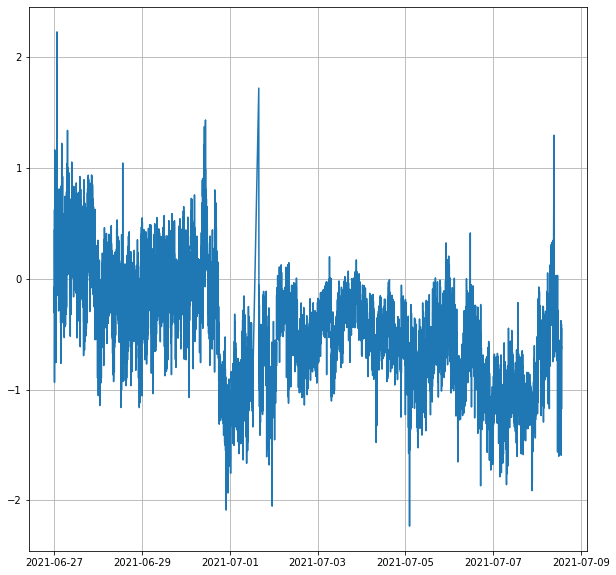

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(merged['datetime'],changes_high)
plt.grid()
#plt.plot(range(len(changes_low)),changes_low)

In [ ]:
num_mins = len(merged)
results = {'mean':[],'std':[]}
for t in range(0,num_mins,30):
  d = []
  for j in range(30):
    try:
      d.append((changes_high[j+t]+changes_low[j+t])/2)
    except:
      break
  results['mean'].append(np.mean(d))
  results['std'].append(np.std(d))
 # results.append((np.mean(d), np.std(d)))
results = pd.DataFrame(results)

In [ ]:
changes_high = []
changes_low = []
for i in range(len(merged)):
  changes_high.append((merged['highDER'].iloc[i]-merged['highBIN'].iloc[i]))
  if changes_high[-1]==0:
    changes_high[-1]=0.001
  changes_low.append((merged['lowDER'].iloc[i]-merged['lowBIN'].iloc[i]))
deltas1 = (-np.array(changes_high[0:-2])+np.array(changes_high[1:-1]))/np.array(changes_high[0:-2])
deltas2 = (-np.array(changes_high[1:-1])+np.array(changes_high[2:]))/np.array(changes_high[1:-1])
np.corrcoef(deltas1,deltas2)

array([[ 1.00000000e+00, -8.86398885e-05],
       [-8.86398885e-05,  1.00000000e+00]])

In [ ]:
for i in changes_high:
  if i==0:
    print(i)

In [ ]:
step = 0.05
print(' q \t   v')
for i in np.arange(0,1,step):
  print(np.around(i+step,2),'\t',np.around(np.quantile(np.array(results['mean'].iloc[1:].to_list())-np.array(results['mean'].iloc[0:-1].to_list()),i+step),2))


 q 	   v
0.05 	 -0.25
0.1 	 -0.21
0.15 	 -0.15
0.2 	 -0.12
0.25 	 -0.09
0.3 	 -0.07
0.35 	 -0.05
0.4 	 -0.03
0.45 	 -0.02
0.5 	 -0.0
0.55 	 0.01
0.6 	 0.03
0.65 	 0.05
0.7 	 0.06
0.75 	 0.08
0.8 	 0.11
0.85 	 0.14
0.9 	 0.19
0.95 	 0.26
1.0 	 0.44


In [ ]:
np.array(results['mean'].iloc[1:].to_list())-np.array(results['mean'].iloc[0:-1].to_list())

array([-3.03367314e-01,  2.32680176e-01,  2.09462655e-01,  2.12290110e-01,
        2.73263118e-01, -3.87768279e-02, -3.61790601e-01,  1.57985785e-01,
        4.90747963e-01, -1.79442452e-02, -1.70231084e-01, -4.60817957e-01,
        2.68213151e-01,  3.88709541e-01,  1.08525766e-01,  9.05167768e-01,
       -9.58386701e-02, -4.77515015e-01,  7.11873015e-04,  1.02374726e+00,
        4.53878267e-01,  7.46959071e-02,  1.93419547e-01,  3.97310186e-01,
        4.30957547e-01, -3.20865772e-01, -1.15928998e+00, -6.94472354e-01,
        1.81851024e-01, -2.94005216e-01,  4.53418239e-01,  2.55453929e-01,
        8.91414769e-02,  3.40170696e-01, -3.11775273e-01, -6.39783979e-01,
       -4.57715313e-01, -6.80120931e-02, -6.16479897e-02,  3.30933018e-01,
        8.71290292e-02, -2.95095949e-01,  1.87080739e-01,  2.45540307e-01,
        7.71487751e-01, -2.22586285e-01,  6.04544691e-01, -1.90879608e-01,
        1.28399370e-01, -7.59257514e-02,  4.04633575e-01,  1.04391005e-01,
        1.83871310e-01,  

In [ ]:
results['mean'].iloc[0:-1]

0     -3.912463
1     -4.140524
2     -4.334728
3     -4.324994
4     -4.017415
         ...   
354   -0.979921
355   -1.059557
356   -0.905990
357   -0.664541
358   -0.313938
Name: mean, Length: 359, dtype: float64

# Трейдингвью, но спред

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/gdrive')
SPREAD_candles = pd.read_csv("/content/gdrive/My Drive/Quant/data/tradingview/HUOBI_ETH24U2021-KRAKEN_ETHUSD24U, 1.csv")
dat = []
for i in range(0,len(SPREAD_candles)):
  dat.append(pd.to_datetime(datetime.datetime.fromtimestamp(SPREAD_candles['time'].iloc[i]).strftime('%Y-%m-%d %H:%M:%S')))
SPREAD_candles['datetime']=dat
SPREAD_candles[SPREAD_candles['datetime']>pd.to_datetime('2021-07-01')]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,time,open,high,low,close,Volume,Volume MA,datetime
14862,1625097660,7.231,7.231,1.268,1.268,90836,50785.5,2021-07-01 00:01:00
14863,1625097720,1.329,5.885,1.329,5.885,129194,56363.0,2021-07-01 00:02:00
14864,1625097780,-1.107,2.961,-1.107,2.961,36630,56346.1,2021-07-01 00:03:00
14865,1625097840,-3.824,5.177,-3.824,5.177,18918,55690.7,2021-07-01 00:04:00
14866,1625097900,-1.938,-1.938,-2.851,-2.851,101200,59626.9,2021-07-01 00:05:00
...,...,...,...,...,...,...,...,...
28551,1625919600,6.218,8.579,3.956,7.881,35280,46860.9,2021-07-10 12:20:00
28552,1625919660,7.883,10.471,6.347,6.354,63310,47904.5,2021-07-10 12:21:00
28553,1625919720,6.220,8.004,3.773,4.590,31170,48325.2,2021-07-10 12:22:00
28554,1625919780,4.288,5.737,3.636,4.334,4898,46622.8,2021-07-10 12:23:00


In [ ]:
a = SPREAD_candles[['time','datetime','high']]
b = SPREAD_candles[['time','datetime','low']]
c = SPREAD_candles[['time','datetime','open']]
d = SPREAD_candles[['time','datetime','close']]
a.columns = ['time','datetime','price']
b.columns = ['time','datetime','price']
c.columns = ['time','datetime','price']
d.columns = ['time','datetime','price']
candles = pd.concat([a,b,c,d,])
candles.sort_values('time',inplace = True)

In [ ]:
candles['rolling'] = candles['price'].rolling(4260).mean()
candles['ewm'] = (candles['price'].ewm(alpha = 0.001).mean())

(-87.24188849036531,
 0.0,
 1,
 114222,
 {'1%': -3.430407252078982,
  '10%': -2.566783468723998,
  '5%': -2.861565304556664},
 648152.732188479)

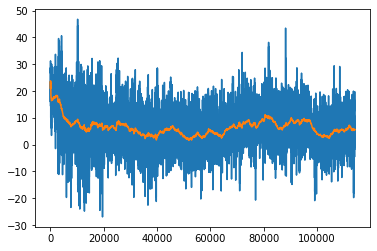

In [ ]:
plt.plot(range(len(candles['datetime'])),candles['price'])
plt.plot(range(len(candles['datetime'])),candles['ewm'])
from statsmodels.tsa.stattools import adfuller
adfuller(candles['price'],1)

In [ ]:
#уровни
step = 0.05
print(' q \t   v')
levels = []
quantiles = []
for i in np.arange(0,1,step):
  quantiles.append(np.around(i+step,2))
  print(np.around(i+step,2),'\t',np.around(np.quantile(candles['price'],i+step),4))
  levels.append(np.quantile(candles['price'],i+step))

 q 	   v
0.05 	 -2.14
0.1 	 0.14
0.15 	 1.5
0.2 	 2.58
0.25 	 3.44
0.3 	 4.19
0.35 	 4.93
0.4 	 5.61
0.45 	 6.24
0.5 	 6.86
0.55 	 7.48
0.6 	 8.1
0.65 	 8.73
0.7 	 9.43
0.75 	 10.22
0.8 	 11.07
0.85 	 12.08
0.9 	 13.45
0.95 	 15.79
1.0 	 45.07


In [ ]:
hours = pd.date_range(start = '2021-07-01 00:00:00',end = '2021-07-10 00:00:00',freq = '1h')
levels1h = []
delta1h = []
for j in levels:
  k = []
  for i in range(len(hours)-1):
    a = candles[(candles['datetime']>=hours[i]) & (candles['datetime']<hours[i+1])]
    k.append(len(a[a['price']<=j]))
  levels1h.append(np.mean(k))

In [ ]:
hours = pd.date_range(start = '2021-07-01 00:00:00',end = '2021-07-10 00:00:00',freq = '24h')
levels24h = []
delta24h = []
for j in levels:
  k = []
  for i in range(len(hours)-1):
    a = candles[(candles['datetime']>=hours[i]) & (candles['datetime']<hours[i+1])]
    k.append(len(a[a['price']<=j]))
  levels24h.append(np.around(np.mean(k),2))

In [ ]:
hours = pd.date_range(start = '2021-07-01 00:00:00',end = '2021-07-10 00:00:00',freq = '168h')
levels1w = []
delta1w = []
for j in levels:
  k = []
  c = []
  for i in range(len(hours)-1):
    a = candles[(candles['datetime']>=hours[i]) & (candles['datetime']<hours[i+1])]
    k.append(len(a[a['price']<=j]))
  levels1w.append(np.around(np.mean(k),2))


In [ ]:
pd.DataFrame({'prob':quantiles, 'levels':levels, 'average 1h':levels1h, 'average 24h':levels24h, 'average 168h':levels1w})

,prob,levels,average 1h,average 24h,average 168h
0,0.05,-2.14,10.768519,258.44,1490.0
1,0.10,0.14,21.574074,517.78,2947.0
2,0.15,1.50,32.472222,779.33,4459.0
3,0.20,2.58,43.759259,1050.22,5965.0
4,0.25,3.44,54.916667,1318.00,7480.0
5,0.30,4.19,66.462963,1595.11,9137.0
6,0.35,4.93,78.032407,1872.78,10869.0
7,0.40,5.61,89.925926,2158.22,12682.0
8,0.45,6.24,101.652778,2439.67,14506.0
9,0.50,6.86,113.731481,2729.56,16529.0
